In [1]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets

### Getting the CIFAR10 dataset

In [3]:
# download the cifar10 dataset

trainset = datasets.CIFAR10(root='/scratch/cifar10', train=True, download=True, transform=ToTensor())

Files already downloaded and verified


In [4]:
testset = datasets.CIFAR10(root='/scratch/cifar10', train=False, download=False, transform=ToTensor())

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Loading the dataset

In [7]:
loaders = {
    'train': DataLoader(trainset, batch_size=256, shuffle=True, num_workers=1),
    'test': DataLoader(testset, batch_size=512, shuffle=False, num_workers=1)
}

### VGG Model

In [8]:
# The same class that was used in previous experiments but now there is added functionality
#  to save the gradients of the last layer of the network along with the loss at each step

class VGG16(nn.Module):
    def __init__(self, num_classes, batchnorm):
        super(VGG16, self).__init__()
        self.batchnorm = batchnorm
        self.layer1 = self._make_layer(3, 64, batchnorm)
        self.layer2 = self._make_layer(64, 64, batchnorm, maxpool=True)
        self.layer3 = self._make_layer(64, 128, batchnorm)
        self.layer4 = self._make_layer(128, 128, batchnorm, maxpool=True)
        self.layer5 = self._make_layer(128, 256, batchnorm)
        self.layer6 = self._make_layer(256, 256, batchnorm)
        self.layer7 = self._make_layer(256, 256, batchnorm, maxpool=True)
        self.layer8 = self._make_layer(256, 512, batchnorm)
        self.layer9 = self._make_layer(512, 512, batchnorm)
        self.layer10 = self._make_layer(512, 512, batchnorm, maxpool=True)
        self.layer11 = self._make_layer(512, 512, batchnorm)
        self.layer12 = self._make_layer(512, 512, batchnorm)
        self.layer13 = self._make_layer(512, 512, batchnorm, maxpool=True)
        self.layer14 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU(),
        )
        self.layer15 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )
        self.layer16 = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

    def _make_layer(self, in_channels, out_channels, batchnorm, maxpool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        ]
        
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
            
        layers.append(nn.ReLU())
        
        if maxpool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.layer14(out)
        out = self.layer15(out)
        out = self.layer16(out)
        return out

   
    def fit(self, loaders, epochs, device, learning_rate):
        self.to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        # adamoptimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        step_size = torch.linspace(1/2, 4, 10) * learning_rate
        
        loss_variation_list = []
        steps = 0

        grads = []

        for epoch in range(epochs):
            self.train().to(device)

            total_loss = 0
            correct = 0
            total = 0

            for i, (images, labels) in enumerate(loaders['train']):
                self.train().to(device)
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)
                
                outputs = self(images)
                loss = criterion(outputs, labels)
                
                loss.backward()

                # Save the current loss obtained
                loss_variation = loss.item()
                loss_variation_list.append(loss_variation)
                
                # For every 5 epochs, save the gradients of the last layer
                if epoch % 5 == 0:
                    grads.append(self.layer16[0].weight.grad.clone().cpu().detach().numpy())
                
                optimizer.step()

                steps += 1

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            total_loss = total_loss / len(loaders['train'])
            accuracy = 100 * correct / total
            print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, total_loss, accuracy))

        # Return the loss variation and the gradients
        return loss_variation_list, steps, grads

In [9]:
# With batchnorm for 2 different learning rates
model = VGG16(10, True).to(device)
loss_variation_0001, steps, grads_0001 = model.fit(loaders, epochs=30, device=device, learning_rate=0.0001)

model = VGG16(10, True).to(device)
loss_variation_0005, steps, grads_0005 = model.fit(loaders, epochs=30, device=device, learning_rate=0.0005)


# No batchnorm for 2 different learning rates
model_nb = VGG16(10, False).to(device)
loss_variation_0005_nb, steps, grads_nb_0005 = model_nb.fit(loaders, epochs=30, device=device, learning_rate=0.0005)

model_nb = VGG16(10, False).to(device)
loss_variation_0001_nb, steps, grads_nb_0001 = model_nb.fit(loaders, epochs=30, device=device, learning_rate=0.0001)



Epoch: 1, Loss: 1.4347, Accuracy: 46.21%
Epoch: 2, Loss: 0.9227, Accuracy: 67.07%
Epoch: 3, Loss: 0.6873, Accuracy: 76.15%
Epoch: 4, Loss: 0.5098, Accuracy: 82.63%
Epoch: 5, Loss: 0.3679, Accuracy: 87.54%
Epoch: 6, Loss: 0.2725, Accuracy: 90.80%
Epoch: 7, Loss: 0.2089, Accuracy: 93.11%
Epoch: 8, Loss: 0.1568, Accuracy: 94.78%
Epoch: 9, Loss: 0.1267, Accuracy: 95.81%
Epoch: 10, Loss: 0.1076, Accuracy: 96.41%
Epoch: 11, Loss: 0.0923, Accuracy: 96.97%
Epoch: 12, Loss: 0.0810, Accuracy: 97.46%
Epoch: 13, Loss: 0.0675, Accuracy: 97.82%
Epoch: 14, Loss: 0.0702, Accuracy: 97.72%
Epoch: 15, Loss: 0.0677, Accuracy: 97.70%
Epoch: 16, Loss: 0.0600, Accuracy: 98.02%
Epoch: 17, Loss: 0.0534, Accuracy: 98.22%
Epoch: 18, Loss: 0.0507, Accuracy: 98.36%
Epoch: 19, Loss: 0.0448, Accuracy: 98.51%
Epoch: 20, Loss: 0.0487, Accuracy: 98.45%
Epoch: 21, Loss: 0.0430, Accuracy: 98.60%
Epoch: 22, Loss: 0.0492, Accuracy: 98.39%
Epoch: 23, Loss: 0.0406, Accuracy: 98.69%
Epoch: 24, Loss: 0.0432, Accuracy: 98.62%
E

### Loss Landscape vs Number of steps

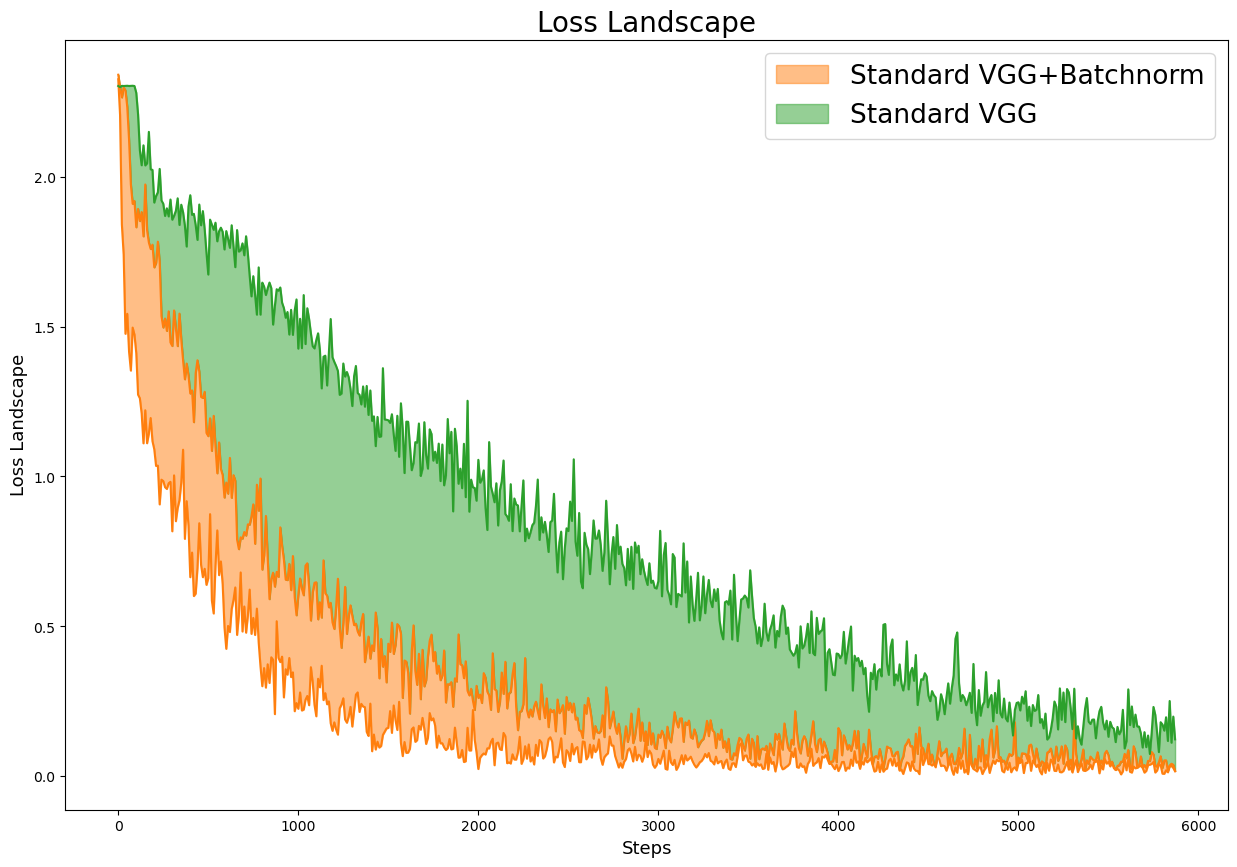

In [229]:
"""
    The following code snippet plots the loss landscape vs the number of steps in the training process
    
    It takes in the loss variation list for each of the 4 models and finds the minimum and maximum loss
    and plots the loss landscape for each of them.
"""

min_loss = []
max_loss = []

min_loss_nb = []
max_loss_nb = []

for i in range(0, len(loss_variation_0005)):
    min_loss.append(np.min([loss_variation_0001[i], loss_variation_0005[i]]))
    max_loss.append(np.max([loss_variation_0001[i], loss_variation_0005[i]]))

for i in range(0, len(loss_variation_0005_nb)):
    min_loss_nb.append(np.min([loss_variation_0001_nb[i], loss_variation_0005_nb[i]]))
    max_loss_nb.append(np.max([loss_variation_0001_nb[i], loss_variation_0005_nb[i]]))

step = 10
steps = np.arange(0, len(min_loss), step)
plt.figure(figsize=(15, 10))

plt.fill_between(steps, min_loss[::step], max_loss[::step],
                alpha=0.5, color='C1', label='Standard VGG+Batchnorm')
plt.plot(steps, min_loss[::step], color='C1')
plt.plot(steps, max_loss[::step], color='C1')

plt.fill_between(steps, min_loss_nb[::step], max_loss_nb[::step],
                alpha=0.5, color='C2', label='Standard VGG')
plt.plot(steps, min_loss_nb[::step], color='C2')
plt.plot(steps, max_loss_nb[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Loss Landscape', fontsize=20)
plt.ylabel('Loss Landscape', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.show()

> From the above graph we can see that the loss landscape is smoother for the model with batch normalization.

### Gradient Predictiveness vs Number of steps

> Gradient Predictiveness: l2 changes in the gradient (b) as we move in the gradient direction.

In [187]:
"""
    The following code snippet finds the l2 norm of the weight gradients for the last layer 
    obtained from the 2 models with batchnorm and finds their minimum and maximum in order
    plot the gradient predictiveness of the model.
"""

grads_0001_copy = np.array(grads_0001)
grads_0005_copy = np.array(grads_0005)

grad_pred_0001 = []
grad_pred_0005 = []

grad_pred_0001 = np.linalg.norm(grads_0001_copy, axis=1, ord=2)
grad_pred_0005 = np.linalg.norm(grads_0005_copy, axis=1, ord=2)

min_curve = []
max_curve = []
for i in range(len(grad_pred_0001)):
    min_curve.append(np.min([grad_pred_0001[i], grad_pred_0005[i]]))
    max_curve.append(np.max([grad_pred_0001[i], grad_pred_0005[i]]))


In [188]:
"""
    The following code snippet finds the l2 norm of the weight gradients for the last layer 
    obtained from the 2 models without batchnorm and finds their minimum and maximum in order
    plot the gradient predictiveness of the model.
"""

grads_nb_0001_copy = np.array(grads_nb_0001)
grads_nb_0005_copy = np.array(grads_nb_0005)

grad_pred_0001_nb = []
grad_pred_0005_nb = []

grad_pred_0001_nb = np.linalg.norm(grads_nb_0001_copy, axis=1, ord=2)
grad_pred_0005_nb = np.linalg.norm(grads_nb_0005_copy, axis=1, ord=2)

min_curve_nb = []
max_curve_nb = []
for i in range(len(grad_pred_0001_nb)):
    min_curve_nb.append(np.min([grad_pred_0001_nb[i], grad_pred_0005_nb[i]]))
    max_curve_nb.append(np.max([grad_pred_0001_nb[i], grad_pred_0005_nb[i]]))


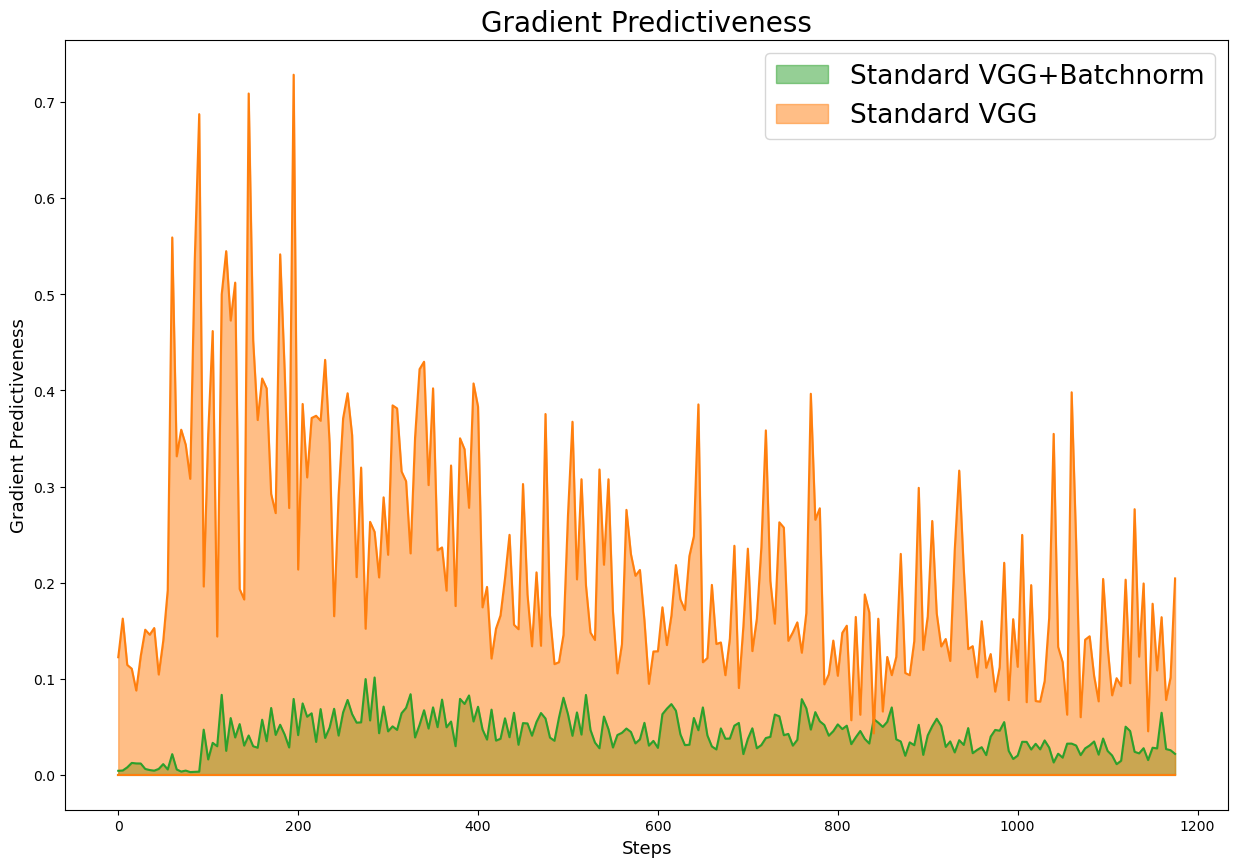

In [192]:
step = 5
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))

plt.fill_between(steps, min_curve[::step], max_curve[::step],
                alpha=0.5, color='C1', label='Standard VGG+Batchnorm')
plt.plot(steps, min_curve[::step], color='C1')
plt.plot(steps, max_curve[::step], color='C1')

plt.fill_between(steps, min_curve_nb[::step], max_curve[::step],
                alpha=0.5, color='C2', label='Standard VGG')
plt.plot(steps, min_curve_nb[::step], color='C2')
plt.plot(steps, max_curve_nb[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Gradient Predictiveness', fontsize=20)
plt.ylabel('Gradient Predictiveness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.show()

> From the above graph we can see that there is high variation in the gradient predictiveness for the model without batch normalization while it is very small for the model with batch normalization.

### Beta Smoothness vs Number of steps

> Beta Smoothness: refers to the maximum difference (in l2-norm) in gradient over distance moved in that direction. 

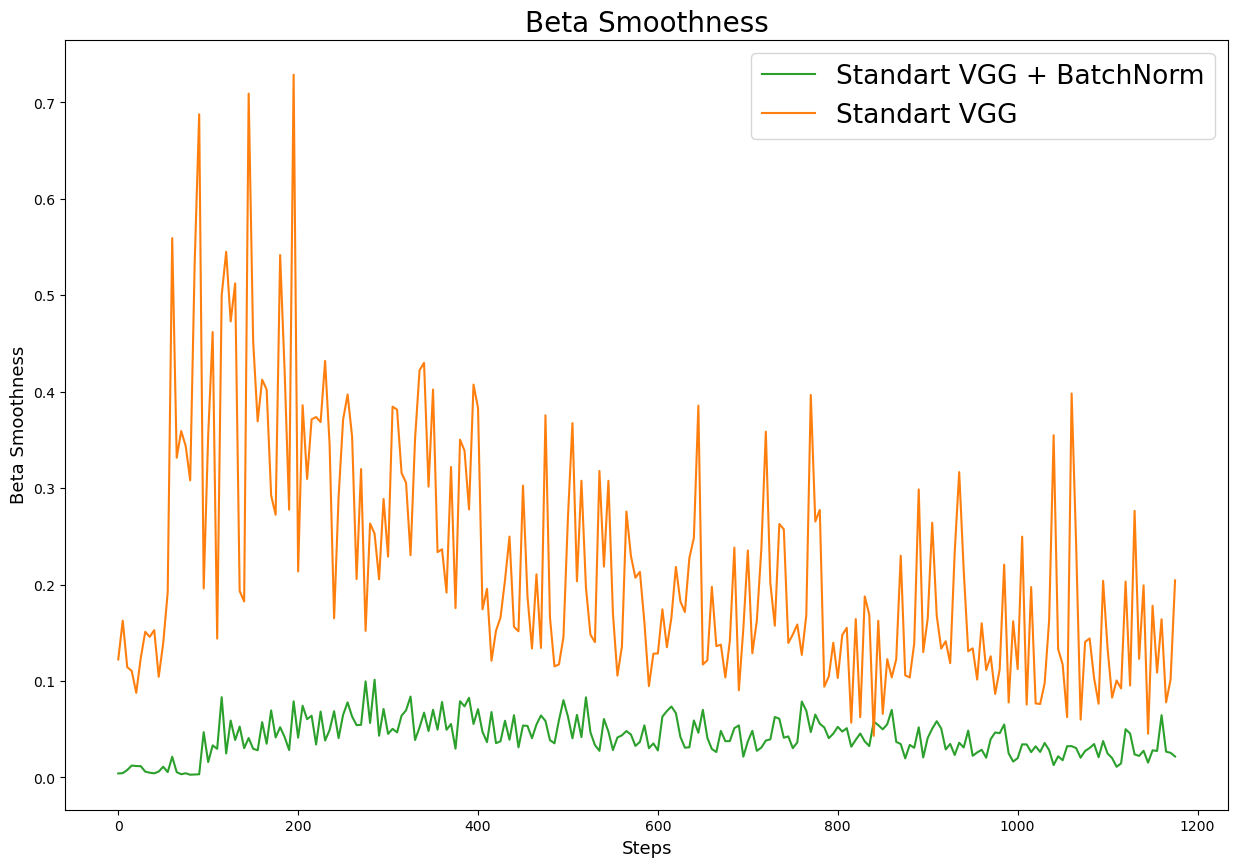

In [194]:
step = 5
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))

plt.plot(steps, min_curve_nb[::step], color='C2')
plt.plot(steps, max_curve[::step], color='C1', label='Standart VGG + BatchNorm')
plt.plot(steps, max_curve_nb[::step], color='C2', label='Standart VGG')

plt.legend(fontsize=19)
plt.title('Beta Smoothness', fontsize=20)
plt.ylabel('Beta Smoothness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.show()

> From the above graph we can see that the beta smoothness is higher for the model without batch normalization while it is very small for the model with batch normalization.